# import files and directories

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import uuid
from PIL import Image
import torch
import torchvision.transforms.functional as F
import random
from torch.utils.data import ConcatDataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset
from torch import flatten
import torch.nn.functional as Fnn
from torch.optim.lr_scheduler import StepLR

In [2]:
POS_PATH = os.path.join("..",'data','positive')
NEG_PATH = os.path.join("..",'data','negetive')
ANC_PATH = os.path.join("..",'data','anchor')

In [4]:
# add directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Untar Labelled Faces in the Wild Dataset

In [7]:
!tar -xf lfw.tgz

In [8]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    EX_PATH = os.path.join('lfw',directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

In [3]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# Data Augmentation

In [59]:
import torchvision.transforms.functional as F
import random
def data_aug(img):
    flag = [0,0,0,0]

    data = []
    while not all(x == 1 for x in flag):
        if flag[0] == 0 and random.randint(0,100) / 100 < 0.5:
            img = F.adjust_brightness(img, brightness_factor=1.1)
            data.append(img)
            flag[0] = 1
        
        if flag[1] == 0 and random.randint(0,100) / 100 < 0.5:
            img = F.adjust_contrast(img, contrast_factor=torch.empty(1).uniform_(0.6, 1).item())
            data.append(img)
            flag[1] = 1
            
        if flag[2] == 0 and random.randint(0,100) / 100 < 0.5:
            img = F.hflip(img)
            data.append(img)
            flag[2] = 1
            
        if flag[3] == 0 and random.randint(0,100) / 100 < 0.5:
            img = F.adjust_saturation(img, saturation_factor=torch.empty(1).uniform_(0.9, 1).item())
            data.append(img)
            flag[3] = 1
        
        
    return data


In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = Image.open(img_path).convert('RGB')
    img_tensor = F.to_tensor(img)
    augmented_images = data_aug(img_tensor)
    for i, image in enumerate(augmented_images):
        image = F.to_pil_image(image)
        image.save(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())))

# Load Data in Dataloader

In [138]:
class MergeImageDataset(Dataset):
    def __init__(self,ANC_PATH  ,POS_PATH, NEG_PATH, types ,transform = None):
        
        self.POS_PATH = POS_PATH
        self.NEG_PATH = NEG_PATH
        self.ANC_PATH = ANC_PATH
        
        self.types = types
        
        self.transform = transform
        
        self.POS_IMG = os.listdir(POS_PATH)
        self.NEG_IMG = os.listdir(NEG_PATH)
        self.ANC_IMG = os.listdir(ANC_PATH)
        
    def __len__(self):
        return len(self.ANC_IMG)

    def __getitem__(self, idx):
        
        anc_dir  = os.path.join(self.ANC_PATH, self.ANC_IMG[idx])
        anc_image = Image.open(anc_dir).convert('RGB')
        
        if self.types == 1: 
            pos_dir  = os.path.join(self.POS_PATH, self.POS_IMG[idx])
            pos_image = Image.open(pos_dir).convert('RGB')

        if self.types == 0: 
            neg_dir  = os.path.join(self.NEG_PATH, self.NEG_IMG[idx])
            neg_image = Image.open(neg_dir).convert('RGB')
        
        data = [anc_image, pos_image if self.types == 1 else neg_image, torch.ones(1) if self.types == 1 else torch.zeros(1) ]

        if self.transform:
            data[0] = self.transform(data[0])
            data[1] = self.transform(data[1])
        
        return data

In [139]:
transform = transforms.Compose([transforms.Resize(100),
                                transforms.ToTensor()])

In [140]:
positive = MergeImageDataset(ANC_PATH, POS_PATH, NEG_PATH, types = 1, transform = transform)
negtive = MergeImageDataset(ANC_PATH, POS_PATH, NEG_PATH, types = 0, transform = transform)

In [141]:
data = ConcatDataset([negtive,positive])

In [142]:
# Split the individual datasets into training and validation parts
num_samples = len(data)
indices = list(range(num_samples))
np.random.shuffle(indices)
split = int(np.floor(0.4 * num_samples))  # Use 20% of data for validation
print(split)
train_indices, val_indices = indices[split:], indices[:split]

# Create samplers for the training and validation parts
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


2352


In [143]:
# Create data loaders for the training and validation parts
train_loader = DataLoader(data, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(data, batch_size=32, sampler=val_sampler)

# Build Model

In [144]:
class Embedding(nn.Module):
    def __init__(self):
            super(Embedding, self).__init__()

            self.conv_1 = nn.Conv2d(3, 64,kernel_size=(10, 10))
            self.relu_1 = nn.ReLU()
            self.maxpool_1 = nn.MaxPool2d(2, stride = 2 ,padding = 1)
            
            self.conv_2 =  nn.Conv2d(64, 128,kernel_size=(7, 7))
            self.relu_2 =  nn.ReLU()
            self.maxpool_2 = nn.MaxPool2d(2 , 2)
            
            self.conv_3 =  nn.Conv2d(128, 128,kernel_size=(4, 4))
            self.relu_3 =  nn.ReLU()
            self.maxpool_3 =  nn.MaxPool2d(2, 2, padding = 1)
            
            self.conv_4 =  nn.Conv2d(128, 256,kernel_size=(4, 4))
            self.relu_4 =  nn.ReLU()
            self.flatten = nn.Flatten(start_dim=1)
            
            self.normalization_64 =  nn.BatchNorm2d(64)
            self.normalization_128 =  nn.BatchNorm2d(128)

            self.linear = nn.Linear(256 * 6 * 6, 4096)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.maxpool_1(x)
        x = self.normalization_64(x)
        
        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.maxpool_2(x)
        x = self.normalization_128(x)
        
        x = self.conv_3(x)
        x = self.relu_3(x)
        x = self.maxpool_3(x)
        x = self.normalization_128(x)
        
        x = self.conv_4(x)
        x = self.relu_4(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        
        return x
        

In [145]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.embeder = Embedding()
        self.classifier = nn.Linear(4096,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_image, validation_image):
        input_image = self.embeder(input_image)
        validation_image = self.embeder(validation_image)
        result = torch.abs(input_image - validation_image)
        x = self.classifier(result)
        x = self.sigmoid(x)
        return x 
        

In [146]:
def round(data):
    for i, value in enumerate(data):
        data[i] = 0 if value < 0.5 else 1
    return data

In [147]:
import matplotlib.pyplot as plt

def plot_metrics(acc_data, loss_data, epochs):
    plt.figure(figsize=(10, 5))
    
    # Plot accuracy data
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), acc_data, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    
    # Plot loss data
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), loss_data, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    
    # Adjust subplot spacing
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    

In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics


torch.manual_seed(34)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Create an instance of the SiameseNetwork
siamese_net = SiameseNetwork().to(device)

# Define the loss function (e.g., Binary Cross Entropy)
criterion =  nn.BCELoss()

# Define the optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.Adam(siamese_net.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

print(len(train_loader))

accuracies = []
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    total_samples = 0
    # Iterate over the training dataset
    for i, (input_image, validation_image, label) in enumerate(train_loader):     
        optimizer.zero_grad()  # Zero the gradients
        
        input_image = input_image.to(device)
        validation_image = validation_image.to(device)
        label = label.to(device)
        # Forward pass
        output = siamese_net(input_image, validation_image)

        # Compute the loss
        loss = criterion(output, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        train_loss += loss.item()
        total_samples += label.size(0)  # Increment total_samples by the batch size
    
    avg_train_loss = train_loss / total_samples
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    
        # Evaluate the model on the validation set

    acc_batches = 0
    val_loss = 0.0
    val_total = 0
    total_samples = 0
    correct_val = 0
    val_correct = 0
    with torch.no_grad():
        for i, (input_image, validation_image, label) in enumerate(val_loader):
            
            input_image = input_image.to(device)
            validation_image = validation_image.to(device)
            label = label.to(device)
            
            # Move inputs and labels to the GPU
            output = siamese_net(input_image, validation_image)
            loss = criterion(output, label)
            result = round(output)
            
            val_loss += loss.item()
            total_samples += label.size(0)  # Increment total_samples by the batch size
            val_correct += (result == label).sum().item()
   
            
        avg_val_loss = val_loss / total_samples
        
        print(f"Val Total Loss %f :" %(val_loss))
        print(f"Val Average Loss %f :" % (avg_val_loss))
        print(f"Val Accuracy %.2f :" % (100 * (val_correct / total_samples ) ))
        accuracies.append(100 * (val_correct / total_samples ))
        losses.append(avg_val_loss)


111
Epoch [1/10]
Val Total Loss 1.711492 :
Val Average Loss 0.000728 :
Val Accuracy 99.06 :
Epoch [2/10]
Val Total Loss 0.492159 :
Val Average Loss 0.000209 :
Val Accuracy 99.96 :
Epoch [3/10]
Val Total Loss 0.210313 :
Val Average Loss 0.000089 :
Val Accuracy 99.87 :
Epoch [4/10]
Val Total Loss 0.780837 :
Val Average Loss 0.000332 :
Val Accuracy 99.83 :
Epoch [5/10]
Val Total Loss 0.331651 :
Val Average Loss 0.000141 :
Val Accuracy 99.96 :
Epoch [6/10]
Val Total Loss 0.195345 :
Val Average Loss 0.000083 :
Val Accuracy 99.87 :
Epoch [7/10]
Val Total Loss 0.027526 :
Val Average Loss 0.000012 :
Val Accuracy 100.00 :
Epoch [8/10]
Val Total Loss 0.078432 :
Val Average Loss 0.000033 :
Val Accuracy 99.96 :
Epoch [9/10]
Val Total Loss 0.013934 :
Val Average Loss 0.000006 :
Val Accuracy 100.00 :
Epoch [10/10]
Val Total Loss 0.011780 :
Val Average Loss 0.000005 :
Val Accuracy 100.00 :


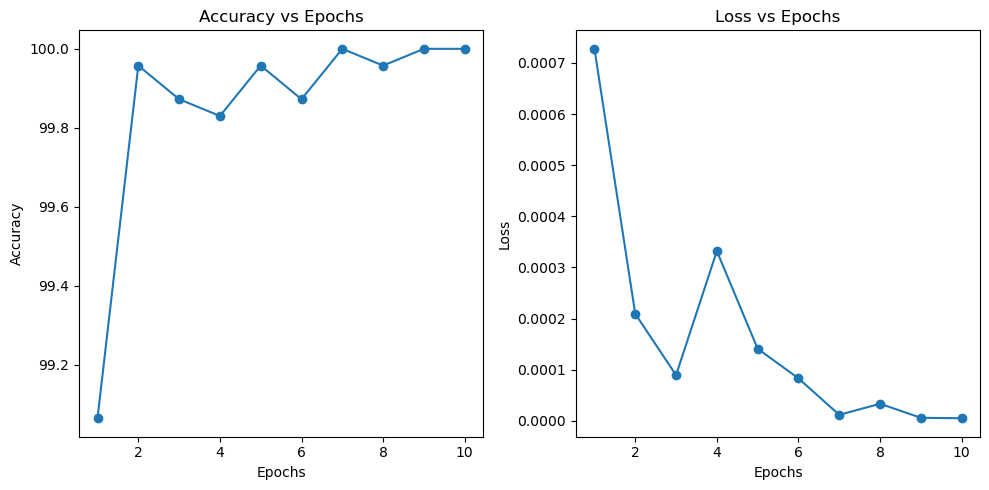

In [149]:
plot_metrics(accuracies, losses, 10 )

# Playing

# Testing

In [156]:
TEST_NEG_PATH = os.path.join("..","test","NEG")
TEST_POS_PATH = os.path.join("..","test","POS")
TEST_ANC_PATH = os.path.join("..","test","ANC")

transform = transforms.Compose([transforms.Resize((100,100)),
                                transforms.ToTensor()])

postive = MergeImageDataset(TEST_ANC_PATH, TEST_POS_PATH, TEST_NEG_PATH, types = 1, transform = transform)
negtive = MergeImageDataset(TEST_ANC_PATH, TEST_POS_PATH, TEST_NEG_PATH, types = 0, transform = transform)
data = ConcatDataset([negtive,positive])

In [157]:
test_loader_pos = DataLoader(postive)
test_loader_neg = DataLoader(negtive)

In [158]:
with torch.no_grad():
    val_correct = 0
    total_samples = 0
    for i, (input_image, validation_image, label) in enumerate(test_loader_pos):
            input_image = input_image.to(device)
            validation_image = validation_image.to(device)
            output = siamese_net(input_image, validation_image)
            result = 1 if output >= 0.5 else 0
            val_correct += (result == label).sum().item()
            total_samples += label.size(0)
            print(f"predicted {result} and true is {label} with this output{output}")
            print('-------------------------------------------')

    print("---------------------NEGATIVES-----------------------------------------")
    for i, (input_image, validation_image, label) in enumerate(test_loader_neg):
            input_image = input_image.to(device)
            validation_image = validation_image.to(device)
            output = siamese_net(input_image, validation_image)
            result = 1 if output >= 0.5 else 0
            val_correct += (result == label).sum().item()
            total_samples += label.size(0)
            print(f"predicted {result} and true is {label} with this output{output}")
            print('-------------------------------------------')
            
    print(f"Accuracy %.2f :" % (100 * (val_correct / total_samples) ))

predicted 1 and true is tensor([[1.]]) with this outputtensor([[1.0000]], device='cuda:0')
-------------------------------------------
predicted 1 and true is tensor([[1.]]) with this outputtensor([[0.9845]], device='cuda:0')
-------------------------------------------
predicted 1 and true is tensor([[1.]]) with this outputtensor([[0.9871]], device='cuda:0')
-------------------------------------------
predicted 1 and true is tensor([[1.]]) with this outputtensor([[0.9999]], device='cuda:0')
-------------------------------------------
predicted 1 and true is tensor([[1.]]) with this outputtensor([[1.]], device='cuda:0')
-------------------------------------------
predicted 1 and true is tensor([[1.]]) with this outputtensor([[1.]], device='cuda:0')
-------------------------------------------
predicted 1 and true is tensor([[1.]]) with this outputtensor([[1.0000]], device='cuda:0')
-------------------------------------------
predicted 1 and true is tensor([[1.]]) with this outputtensor([

In [29]:
def imgshow(image):
    image = np.squeeze(image) 
    image = np.transpose(image, (1, 2, 0))
    plt.figure(figsize=(10, 8)) 
    plt.imshow(image)  # Display the image using a grayscale colormap
    plt.show()